<a target="_blank" href="https://colab.research.google.com/github/YDayoub/MachineLearning_notebooks/blob/main/Ch3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Import libraries

In [50]:
from sklearn import datasets
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets


## Loading Iris dataset

In [51]:
class Dataset:
    def __init__(self,
                 x, 
                 y, 
                 features_labels=None, 
                 classes_labels=None):
        self.x = x
        self.y = y
        
        self.features_labels = (features_labels if features_labels is not None
                                else ['feat_'+str(i) for i in range(x.shape[1])])
        self.classes_labels = (classes_labels if classes_labels is not None
                              else ['class_'+str(cls) for cls in np.unique(y)])
        
    def __str__(self):
        template = "Dataset has {} instances\nFeatures: {}\nclasses{}"
        return template.format(self.x.shape[0],
                              self.features_labels,
                              self.classes_labels)



In [52]:
iris = datasets.load_iris()
print("Iris object has the following information:\n{}".format("\n".join(iris.keys())))
print("="* 10)
features_idx = [2, 3]
iris_x, iris_y = iris.data[:, features_idx], iris.target
iris_x[:, 0] = iris_x[:, 0] * 10000 # convert from cm to um to show the effect of scaling the data.
class_names = iris.target_names
features_names = iris.feature_names
features_names[features_idx[0]] = features_names[features_idx[0]].replace("cm", "um")  
iris_dataset = Dataset(iris_x, 
                       iris_y, 
                       np.array(features_names)[features_idx],
                      class_names)
print(iris_dataset)


Iris object has the following information:
data
target
frame
target_names
DESCR
feature_names
filename
data_module
Dataset has 150 instances
Features: ['petal length (um)' 'petal width (cm)']
classes['setosa' 'versicolor' 'virginica']


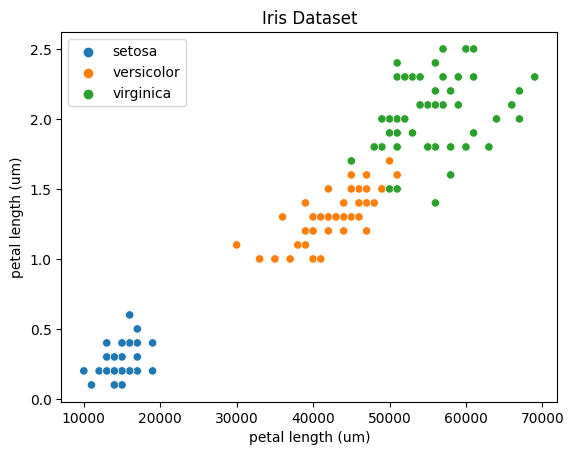

In [53]:
sns.scatterplot(x=iris_dataset.x[:, 0], y=iris_dataset.x[:, 1], 
               hue=[class_names[target] for target in iris_dataset.y])
plt.title("Iris Dataset");
plt.xlabel(iris_dataset.features_labels[0])
plt.ylabel(iris_dataset.features_labels[0])
plt.show()


In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(iris_dataset.x, 
                                                    iris_dataset.y,
                                                      test_size=0.3,
                                                      random_state=1000,
                                                      stratify=iris_dataset.y)
print(f"original data: {np.bincount(iris_dataset.y)}")
print(f"train data: {np.bincount(y_train)}")
print(f"test data: {np.bincount(y_test)}")

original data: [50 50 50]
train data: [35 35 35]
test data: [15 15 15]


## Creating moondataset

In [55]:
from sklearn.datasets import make_moons
moon_data = make_moons(1000,
                      noise=0.1)
moon_dataset = Dataset(moon_data[0], 
                       moon_data[1])

## Helper functions

In [56]:
from sklearn.model_selection import train_test_split
def split_data(x, y, random_state=1, test_size=0.3):    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                      test_size=test_size,
                                                      random_state=random_state,
                                                      stratify=y)
    return x_train, x_test, y_train, y_test

In [57]:
import sklearn
from sklearn.metrics import accuracy_score

class NoScaling:
    def __getattr__(self, attr):
        return lambda x: x

def scale_data(x_train, x_test, scaler_name):
    try:
        sc = getattr(sklearn.preprocessing, scaler_name)()
    except AttributeError as e:
        sc = NoScaling()

    x_train_sc = sc.fit_transform(x_train)
    x_test_sc = sc.transform(x_test)
    return sc, x_train_sc, x_test_sc

In [58]:
from matplotlib.colors import ListedColormap
colors = ['red', 'green', 'blue', 'cyan']
def plot_region(clf, 
                x, 
                y, 
                nb_points=1000, 
                axis_labels=None,
                classes_labels=None,
                title=None):
    x1min, x1max = x[:, 0].min(), x[:, 0].max()
    x2min, x2max = x[:, 1].min(), x[:, 1].max()
    offset1, offset2 = 0.1*(x1max-x1min), 0.1*(x2max-x2min)
    res1 = (x1max-x1min + 2*offset1) / nb_points
    res2 = (x2max-x2min + 2*offset2) / nb_points
    cmap = ListedColormap(colors[:len(np.unique(y))])
    xx1, xx2 = np.meshgrid(np.arange(x1min-offset1, x1max+offset1, res1),
                          np.arange(x2min-offset2, x2max+offset2, res2))
    labels = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    labels = labels.reshape(xx1.shape)
    plt.contourf(xx1, xx2, labels, cmap=cmap, alpha=0.3)
    classes = np.unique(y)
    for idx, cls in enumerate(classes):
        plt.scatter(x[y == cls, 0],
                   x[y == cls, 1],
                   c=colors[idx],
                   edgecolor='black',
                   label=classes_labels[cls])
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    plt.legend()

    if title:
        plt.title(title)
    plt.show()    

In [59]:
def run_model(model, dataset, scaler=None, **kwargs):
    x_train, x_test, y_train, y_test = split_data(dataset.x, dataset.y, random_state=1000)
    sc, x_train_sc, x_test_sc = scale_data(x_train, x_test, scaler)

    clf = model(**kwargs)
    clf.fit(x_train_sc, y_train)
    preds = clf.predict(x_test_sc)
    score = accuracy_score(y_test, preds)

    plot_region(clf, 
                sc.transform(dataset.x), 
                dataset.y, 
                axis_labels=dataset.features_labels,
                classes_labels=dataset.classes_labels,
                title=f"Accuracy of {model.__name__}: {score*100:.0f}% using {kwargs}")
    return clf


## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
@widgets.interact
def fit_logistic_regression(C=(1, 500, 10),
                            random_seed='1',
                            scaler = ["NoScaling", "StandardScaler", "MinMaxScaler", "RobustScaler"],
                            multi_class=['ovr', 'multinomial']):
    random_seed = int(random_seed)
    run_model(LogisticRegression, iris_dataset, random_state=random_seed, scaler=scaler, multi_class=multi_class, C=C)


# try seed 1 and 1000

interactive(children=(IntSlider(value=241, description='C', max=500, min=1, step=10), Text(value='1', descript…

*Why logistic_regression prone to outliers?*  

Let's consider an example where we have a simple problem of classifying positive and negative numerical data. However, there is an outlier in the positive data that actually has a negative value.

In [61]:
import numpy as np
import pandas as pd
x = np.linspace(-10, 10 , 10)
x[-1] = 10
y = (x > 0).astype(int)
y[x == 10] = 0
pd.DataFrame({'x': x,
             'y': y}).T

,0,1,2,3,4,5,6,7,8,9
x,-10.0,-7.777778,-5.555556,-3.333333,-1.111111,1.111111,3.333333,5.555556,7.777778,10.0
y,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0


As the distance of the instance to desicion boundary increases, model increases its confidence in its output. Suppose that we have $ w=1, b=0 $, then for previous example, we have $ z = w \times x + b = 10 = 1 \times 10 + 0 = 10 $. 

If we calculated the sigmoid, we get:
$$ sigmoid(10) = \frac{1}{1+e^{-10}} \approx 0.999955$$

And the loss for this instance is:
$$ l_i \approx -log(1 - 0.999955) \approx 10 $$
Supopse that the model for other data, is just outputing 0.5, then 
$$ l \approx 0.6 $$
This means that $l_i$ will effect the model about 17 times more than other samples.

## Overfitting

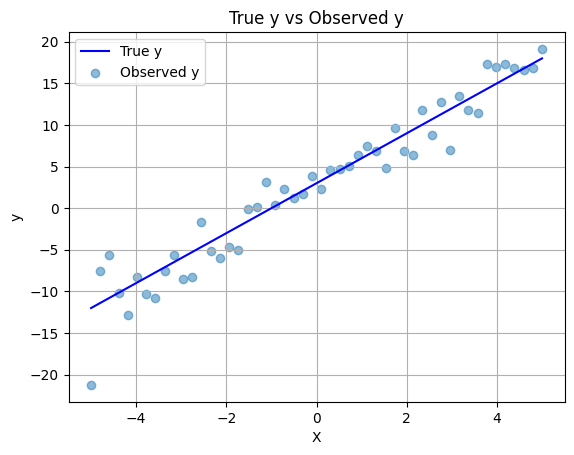

In [62]:
# Generating Data
import numpy as np

x = np.linspace(-5, 5 , 50)
a, b = 3, 3
noise_mul = np.random.randn(*x.shape)
noise_add = np.random.randn(*x.shape)
true_y = a * x + b
observed_y = (a + noise_mul) * x + (noise_add + b)
x = x.reshape(-1, 1)
plt.plot(x, true_y, '-b', label='True y')
plt.scatter(x, observed_y, alpha=0.5, 
            label='Observed y')
plt.grid(True)
plt.xlabel("X")
plt.ylabel("y")
plt.title("True y vs Observed y")
plt.legend()
plt.show()

In [63]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse

@widgets.interact
def fit_polynomial_data(degree = (1, 20, 1),
                       reg_name=['LinearRegression', 'Ridge'],
                       alpha= (1, 15, 1)):    
    x_train, x_test, y_train, y_test = train_test_split(x, observed_y, random_state=1000)
    reg = getattr(linear_model, reg_name)
    try:
        reg = reg(alpha=10**alpha)
    except:
        reg = reg()
        

    model = Pipeline([("poly", PolynomialFeatures(degree=int(degree))),
                     ("cls", reg)])
    model.fit(x_train, y_train)
    train_score = mse(model.predict(x_train), y_train)
    test_score = mse(model.predict(x_test), y_test)

    plt.plot(x, model.predict(x), label='Model_prediction')
    plt.plot(x, true_y, '--',label="True y")
    plt.scatter(x_train, y_train, alpha=0.5, 
                label='Train data')
    plt.scatter(x_test, y_test, alpha=0.5,
                marker='+', label='Test data')
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(f"Train mse loss {train_score:.2f}, test mse loss {test_score:.2f},\n ratio(test/train) {test_score/train_score:.2f}")
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=10, description='degree', max=20, min=1), Dropdown(description='reg_name…

## SVC

Let's start by exploring the [SVC with linear kernel](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

To define a model using this kernel, we can utilize the following code:

```python
clf = sklearn.svm.SVC(C)
```

Please note that when utilizing the linear kernel, other arguments such as `gamma` and `degree` are disregarded.

The primary objective of the SVC algorithm is to maximize the separation of the hyperplanes of the classes. This entails maximizing the distance between the decision boundary and the closest samples from each class. The aim is to achieve the widest possible margin between the classes.

In practice, it is often not feasible to achieve perfect separation, so we allow for some training error. The level of training error is controlled by the `C` parameter. A smaller value of `C` corresponds to a higher tolerance for training errors, resulting in a larger margin and less susceptibility to overfitting. Conversely, a larger value of `C` aims for less training error, which leads to a smaller margin and a higher likelihood of overfitting.

In [64]:
from sklearn.svm import LinearSVC


@widgets.interact
def fit_SVC(C=(1, 6, 1),
            random_seed='1',
            scaler = ["NoScaling", "StandardScaler", "MinMaxScaler", "RobustScaler"],
           ):
    random_seed = int(random_seed)
    run_model(LinearSVC, moon_dataset, random_state=random_seed, scaler=scaler, C=10**C)


interactive(children=(IntSlider(value=3, description='C', max=6, min=1), Text(value='1', description='random_s…

### kernels

Based on the previous example, it is evident that we cannot accurately separate the classes as they are not linearly separable.

To address this, one solution is to generate more distinctive features and then utilize the `SVC` algorithm. This process can be divided into two steps:

1. Generating features: We can generate additional features, for example using `PolynomialFeatures`. This step aims to enhance the separability of the classes.
2. Feeding features to `SVC`: Once the features are generated, we can pass them as input to the `SVC` algorithm.

Consider the following example using a polynomial kernel. We generate the features using `PolynomialFeatures` and then feed the transformed output to `SVC`:

```python
model = Pipeline([
    ("poly", PolynomialFeatures(degree=degree)),
    ("cls", SVC())
])
```

While the previous approach works well, it is important to note that increasing the degree of the polynomial leads to more computed features, resulting in higher memory and computation costs.

To overcome this challenge, we can employ a technique known as the **kernel trick**. The optimization formulation of the problem actually requires **the dot product of the transformed features**, not the transformed features themselves, ie we need $\phi(\textbf{a})^T \phi(\textbf{b})$. This dot product can be calculated(sometimes approximated) using the original features, $\textbf{a}$ and $\textbf{b}$.

There are several popular kernels and their corresponding dot product calculations:

1. Linear Kernel: $K(\textbf{a}, \textbf{b}) = \textbf{a}^T\textbf{b}$
2. Polynomial Kernel: $K(\textbf{a}, \textbf{b}) = (\gamma\textbf{a}^T\textbf{b}+r)^d$
3. Gaussian RBF Kernel: $K(\textbf{a}, \textbf{b}) = \exp(−\gamma||\textbf{a} − \textbf{b}||^2)$

This trick enable us to use kernel functions without the need of transforming features.
For more information, please look at chapter 5, "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow."

In [65]:
from sklearn.svm import SVC
from functools import partial

# Note to get better results, change max_iter
@widgets.interact
def fit_SVC(C=(1, 6, 1),
            degree = (1, 4, 1),
            random_seed='1',
            scaler = ["NoScaling", "StandardScaler", "MinMaxScaler", "RobustScaler"],
            kernel=['linear', 'poly', 'rbf', 'sigmoid']
           ):
    random_seed = int(random_seed)
    run_model(SVC,moon_dataset, random_state=random_seed, scaler=scaler, C=10**C, 
              kernel=kernel, degree=degree)

interactive(children=(IntSlider(value=3, description='C', max=6, min=1), IntSlider(value=2, description='degre…

# Decision Trees

Let's start by exploring the [DT](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

To define a model in a classification task, we can utilize the following code:

```python
clf = sklearn.tree.DecisionTreeClassifier()
```

The goal of this model is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

Please note that increasing arguments such as `max_leaf_nodes` and `max_depth`, leads to more complex decision rules and fitter model .

To split the nodes at the most informative features, so they define objective function (called Information Gain IG) as follows:
\begin{align}
        IG(D_p, f) = I(D_p)- \sum_{i=1}^m \frac{N_i}{N_p} I(D_i)
    \end{align}
$f$: feature to perform the split.

$D_p,D_i$: dataset of the parent and $i^{th}$ child node.

$I$: our impurity measure.

$N_p$: total number of training examples at the parent node.

$N_i$: number of examples in the $i^{th}$ child node.

Most libraries (including scikit-learn) implement binary decision trees. This means that each parent node is split into two child nodes, $D_{left}$ and $D_{right}$:

\begin{align}
        IG(D_p, f) = I(D_p)- \frac{N_{left}}{N_p} I(D_{left})- \frac{N_{right}}{N_p} I(D_{right})
    \end{align}

There is three **impurity measures** or splitting criteria that are commonly used:

1.   **Gini impurity** ($I_G$)
\begin{align}
         I_G = \sum_{i=1}^c p(i|t)(1-p(i|t)) = 1-\sum_{i=1}^c p(i|t)^2
    \end{align}
2.   **entropy** ($I_H$)
\begin{align}
         I_H = -\sum_{i=1}^c p(i|t)\log_2(p(i|t))
    \end{align}
3.   **classification error** ($I_E$)

\begin{align}
         I_E = 1-\max(p(i|t))
    \end{align}

$p(i|t)$: the proportion of the examples that belong to class $i$ for a particular node $t$.

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

@widgets.interact
def fit_DT( random_seed ='1',
            max_leaf_nodes = (1,10,1),
            max_depth=(1,10,1),
            data_set = {"iris":iris_dataset,"moon":moon_dataset},
            scaler = ["NoScaling", "StandardScaler", "MinMaxScaler", "RobustScaler"],
            criterion=['gini', 'entropy', 'log_loss']
           ):
    random_seed = int(random_seed)
    max_leaf_nodes = int(max_leaf_nodes)
    max_depth = int(max_depth)
    clf = run_model(DecisionTreeClassifier,dataset=data_set, random_state=random_seed, scaler=scaler, max_leaf_nodes=max_leaf_nodes,
              max_depth=max_depth,criterion=criterion)

interactive(children=(Text(value='1', description='random_seed'), IntSlider(value=5, description='max_leaf_nod…